# Tesla Stock Price Prediction, Bayesian Optimization
### Second Semester Capstone

This notebook is an implementation of a Bayesian optimization using the scikit-optimize library

#### Notes:

When testing multi-step prediction with 365 days, a lower percent train was found to produce better results. (70% train versus 80% train). Also got better results when using more recent data. I grabbed a new Tesla stock CSV from Yahoo Finance that now leads up to 12/31/2021. Prior tests with the previous data set yielded results of about 69% error at best

In [1]:
import pandas as pd
import numpy as np
import warnings

#tf.compat.v1.disable_v2_behavior()
from math import sqrt, floor, isnan
from matplotlib import pyplot
from statistics import mean

#imports we know we'll need
# !pip install scikit-optimize if  necessary
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence  

from tensorflow.python.keras import backend as K

# Import keras libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Flatten, RepeatVector, Dropout
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from sklearn.preprocessing import MinMaxScaler

# LSTM Application

## Preparing Data

In [2]:
# Loading Preprocessed Data File
df = pd.read_csv("preprocessedGM_MoreRecent.csv", parse_dates=['Date'],index_col=0)
df.dropna(inplace=True)
df.drop(df.columns.difference(['Date','Close','Tesla Trend','Musk Trend','GM Trend','EV Trend','Coronavirus Trend','Month','Day of the Month','Day of the Week','Day of the Year','Year']), 1, inplace=True)
df = df.loc[(df.index >= '2016-01-01')]

print(df.shape)
df.head(3)

(1573, 11)


C:\Users\thoma\AppData\Local\Temp\ipykernel_28964\1808675091.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['Date','Close','Tesla Trend','Musk Trend','GM Trend','EV Trend','Coronavirus Trend','Month','Day of the Month','Day of the Week','Day of the Year','Year']), 1, inplace=True)


,Close,Tesla Trend,Musk Trend,GM Trend,EV Trend,Coronavirus Trend,Month,Day of the Month,Day of the Week,Day of the Year,Year
Date,,,,,,,,,,,
2016-01-04,33.310001,14.06,1.71,72.00,9.18,0.0,1,4,0,4,2016
2016-01-05,32.430000,12.35,1.80,64.80,13.60,0.0,1,5,1,5,2016
2016-01-06,31.270000,12.16,1.53,62.64,10.54,0.0,1,6,2,6,2016


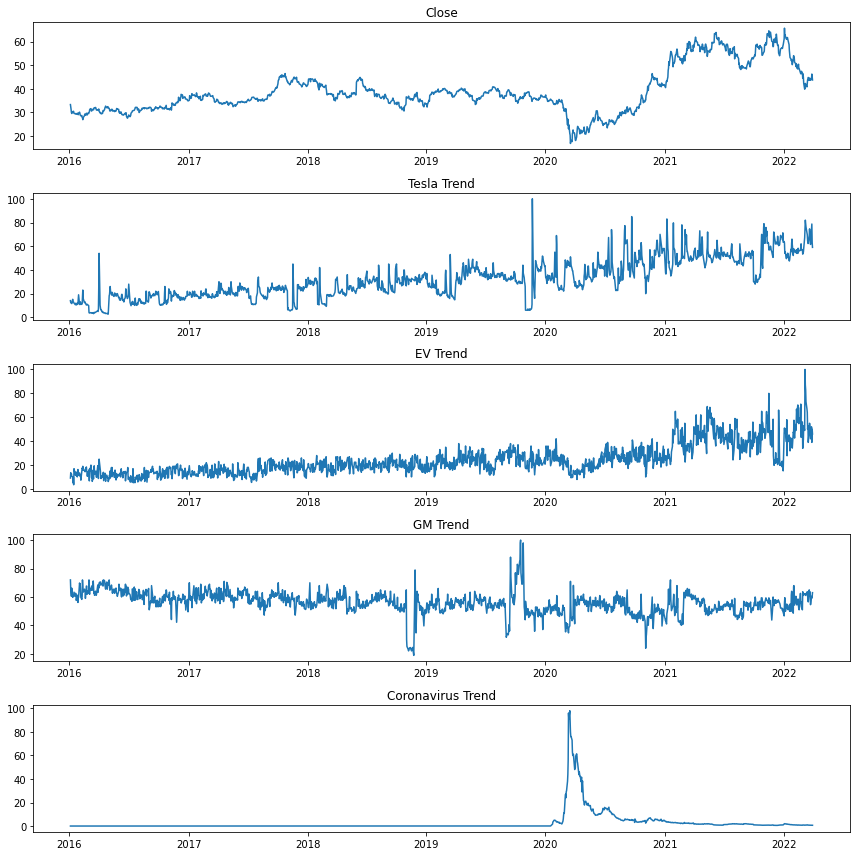

In [3]:
dates = df.index.to_numpy()
pyplot.figure(figsize=(12,12))
pyplot.subplot(5, 1, 1)
pyplot.plot(dates, df["Close"], label="Close")
pyplot.title("Close")
pyplot.subplot(5, 1, 2)
pyplot.plot(dates, df["Tesla Trend"], label="Tesla Trend")
pyplot.title("Tesla Trend")
pyplot.subplot(5, 1, 3)
pyplot.plot(dates, df["EV Trend"], label="EV Trend")
pyplot.title("EV Trend")
pyplot.subplot(5, 1, 4)
pyplot.plot(dates, df["GM Trend"], label="GM Trend")
pyplot.title("GM Trend")
pyplot.subplot(5, 1, 5)
pyplot.plot(dates, df["Coronavirus Trend"], label="Coronavirus Trend")
pyplot.title("Coronavirus Trend")
pyplot.tight_layout()
pyplot.show()

### Functions For Converting Time Series Data For Supervised Learning

In [4]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, col_names, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_temp.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df_temp.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
def split_data(dataframe, columns, n_in, n_out):
    values = dataframe.values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features, makes it easier for the model to train on
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, columns, n_in, n_out)
    # Drop Columns of Variables We Aren't Predicting
    for i in range(1, n_out):
        reframed.drop(reframed.loc[:, ('Tesla Trend(t+%i)' %(i)):('Year(t+%i)' %(i))], axis=1, inplace=True)
    reframed.drop(reframed.loc[:, 'Tesla Trend(t)':'Year(t)'], axis=1, inplace=True)

    y_vals = reframed.iloc[:,n_out*-1:].values
    x_vals = reframed.iloc[:,:n_out*-1].values
    # split into train, test, and prediction sets

    # split into input and outputs
    x_vals, y_vals = x_vals[:, :], y_vals[:, :]
    # reshape input to be 3D [samples, timesteps, features]
    x_vals = x_vals.reshape(-1, n_in, len(columns))

    return x_vals, y_vals

### Conversion of Time Series Data

In [6]:
n_out = 365            # timesteps for output
n_predict = 1          # n_predict = (number of data points you want to predict) / n_out
percent_train = 0.70    # percent as decimal

## Running Model

### Function For Building Model

In [7]:
# Design Network
def build_model(learning_rate, LSTM1, LSTM2, num_layers, dropout1, dropout2, n_out, n_in, n_features):
    model = Sequential()

    model.add(BatchNormalization(name = "batch_norm_0", input_shape = (n_in, n_features)))

    for i in range (num_layers):
        model.add(LSTM(LSTM1, name='lstm_{0}_1'.format(i), return_sequences=True))
        model.add(Dropout(dropout1, name='dropout_{0}_1'.format(i)))
        model.add(BatchNormalization(name='batch_norm_{0}_1'.format(i)))

        model.add(LSTM(LSTM2, name='lstm_{0}_2'.format(i), return_sequences=True))
        model.add(Dropout(dropout2, name='dropout_{0}_2'.format(i)))

    model.add(LSTM(LSTM2, name='LSTM_final', return_sequences=False))
    model.add(Dense(n_out, name='dense', activation="linear", kernel_constraint=NonNeg()))

    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mae', metrics=['accuracy'])

    return model

### Bayesian Optimization

based on https://medium.com/@crawftv/parameter-hyperparameter-tuning-with-bayesian-optimization-7acf42d348e1

Additional info on log-uniform distribution: https://towardsdatascience.com/why-is-the-log-uniform-distribution-useful-for-hyperparameter-tuning-63c8d331698

In [8]:

dim_n_in = Integer(low=1, high=365, name='n_in')
dim_learning_rate = Real(low=9e-5, high=9e-1, prior='log-uniform', name='learning_rate')
dim_LSTM1 = Integer(low=1, high=300, name='LSTM1')
dim_LSTM2 = Integer(low=1, high=300, name='LSTM2')
dim_num_layers = Integer(low=0, high=5, name='num_layers')
dim_dropout1 = Real(low=9e-10, high=9e-1, prior='log-uniform', name='dropout1')
dim_dropout2 = Real(low=9e-10, high=9e-1, prior='log-uniform', name='dropout2')
dim_batch_size = Integer(low=1, high=600, name='batch_size')
dim_patience = Integer(low=10,high=100, name="patience")
dim_num_epochs = Integer(low=10,high=200, name="num_epochs")

dimensions = [
    dim_n_in,
    dim_learning_rate,
    dim_LSTM1,
    dim_LSTM2,
    dim_num_layers,
    dim_dropout1,
    dim_dropout2,
    dim_batch_size,
    dim_patience,
    dim_num_epochs
]

initial_points = [
    [280,0.00971993713639623,247,225,4,7.300627801285873e-08,0.16606138575445825,105,19,14], # NMAE 0.2607
    [48,0.19521125417826246,271,7,3,1.6257310794486974e-06,5.2516676073065695e-09,323,21,30], # NMAE 0.1505
    [231,0.010264476822280313,263,138,4,3.033099898738017e-08,0.0008493238305193479,136,21,119], # NMAE 0.1653
    [280,0.0020229199777142574,125,255,3,5.56759489712845e-06,0.00024147778307501044,84,41,39], # NMAE 0.1469
]

In [9]:

@use_named_args(dimensions=dimensions)
def fitness(n_in, learning_rate, LSTM1, LSTM2, num_layers, dropout1, dropout2, batch_size, patience, num_epochs):
    num_test = max(floor(df.shape[0]*(1-percent_train)), n_out)
    df_test = df.drop(df.tail(n_out).index).tail(num_test+n_in)
    df_train = df.drop(df.tail(n_out+num_test).index)
    train_X, train_y = split_data(df_train, df.columns, n_in, n_out)
    test_X, test_y = split_data(df_test, df.columns, n_in, n_out)
    test_y_mean = np.mean(test_y)
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    model = build_model(
        learning_rate=learning_rate,
        LSTM1=LSTM1,
        LSTM2=LSTM2,
        num_layers=num_layers,
        dropout1=dropout1,
        dropout2=dropout2,
        n_out=n_out,
        n_in=n_in,
        n_features=len(df.columns)
    )
    
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)
    history = model.fit(x=train_X, y=train_y, 
        epochs=num_epochs, 
        batch_size=batch_size, 
        validation_data=(test_X, test_y), 
        shuffle=False,
        verbose=0, 
        callbacks=[early_stopping]
    )
    #return the minimum validation mae for the patience period
    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore', message='All-NaN axis encountered')
        mae = np.nanmin(history.history['val_loss'][-1*patience:])

    # Delete the Keras model with these hyper-parameters from memory.
    del model, early_stopping, history, df_test, df_train, train_X, train_y, test_X, test_y, num_test
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    
    # the optimizer aims for the lowest score
    if isnan(mae):
        return 9999.9999
    normalized_mae = mae/test_y_mean
    return normalized_mae

In [10]:
gp_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    n_calls=15,
    n_jobs=-1,
    kappa=1.96,    # default is 1.96, lower values = more exploitation, higher = more exploration
    noise=1e-5,
    acq_optimizer="lbfgs",
    x0=initial_points,
    n_initial_points=10,
    verbose=True
)

Iteration No: 1 started. Evaluating function at provided point.
(93, 280, 11) (93, 365) (107, 280, 11) (107, 365)
(325, 48, 11) (325, 365) (107, 48, 11) (107, 365)
(142, 231, 11) (142, 365) (107, 231, 11) (107, 365)
(93, 280, 11) (93, 365) (107, 280, 11) (107, 365)
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 133.0380
Function value obtained: 0.2784
Current minimum: 0.2784
Iteration No: 2 started. Evaluating function at provided point.
(244, 129, 11) (244, 365) (107, 129, 11) (107, 365)
Iteration No: 2 ended. Evaluation done at provided point.
Time taken: 23.8638
Function value obtained: 0.4902
Current minimum: 0.2784
Iteration No: 3 started. Evaluating function at provided point.
(36, 337, 11) (36, 365) (107, 337, 11) (107, 365)
Iteration No: 3 ended. Evaluation done at provided point.
Time taken: 21.3334
Function value obtained: 0.3241
Current minimum: 0.2784
Iteration No: 4 started. Evaluating function at provided point.
(126, 247, 11) (126, 365) (107, 247, 

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

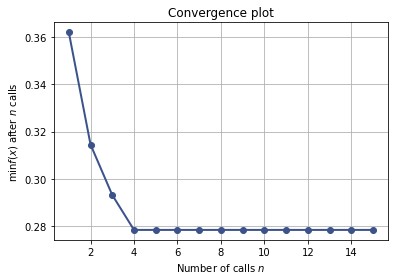

In [11]:
plot_convergence(gp_result)

In [12]:
gp_result.x

[280,
 0.0020229199777142574,
 125,
 255,
 3,
 5.56759489712845e-06,
 0.00024147778307501044,
 84,
 41,
 39]

In [13]:
res_df = pd.DataFrame(data=gp_result.x_iters, columns=['Input Timesteps','Learning Rate','Nodes 1','Nodes 2','Num Layers','Dropout 1','Dropout 2','Batch Size','Patience','Epochs'])
res_df['Normalized MAE'] = gp_result.func_vals
res_df.sort_values('Normalized MAE', inplace=True) 
res_df.head(15)

,Input Timesteps,Learning Rate,Nodes 1,Nodes 2,Num Layers,Dropout 1,Dropout 2,Batch Size,Patience,Epochs,Normalized MAE
3,280,0.002023,125,255,3,5.567595e-06,2.414778e-04,84,41,39,0.278419
2,231,0.010264,263,138,4,3.033100e-08,8.493238e-04,136,21,119,0.293153
1,48,0.195211,271,7,3,1.625731e-06,5.251668e-09,323,21,30,0.314494
7,76,0.000428,5,98,4,7.966257e-01,4.292049e-03,262,100,126,0.322488
5,337,0.003715,259,223,1,1.802557e-09,7.542837e-05,291,73,124,0.324121
6,247,0.017508,182,96,4,1.267263e-05,1.482108e-04,147,89,114,0.350635
14,1,0.202377,281,1,2,4.402913e-06,9.000000e-10,314,19,11,0.353994
0,280,0.009720,247,225,4,7.300628e-08,1.660614e-01,105,19,14,0.361945
13,89,0.023857,60,216,1,9.417039e-06,1.182168e-06,241,19,195,0.364665
10,217,0.008701,278,259,3,7.694586e-01,7.597288e-07,493,52,116,0.371811


## Results

(93, 280, 11) (93, 365) (107, 280, 11) (107, 365)
Trial 1


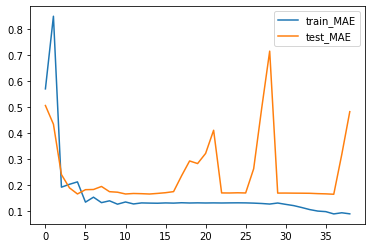

MAE = 0.1643 NMAE = 0.2821
Trial 2


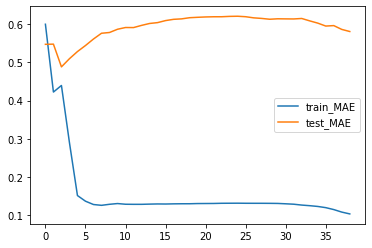

MAE = 0.4882 NMAE = 0.8380
Trial 3


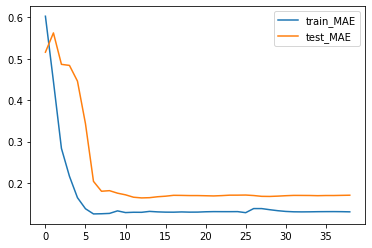

MAE = 0.1638 NMAE = 0.2812
Trial 4


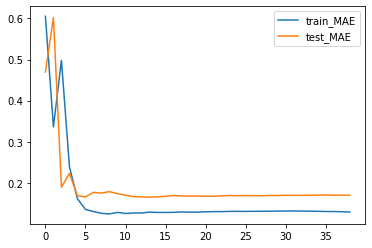

MAE = 0.1652 NMAE = 0.2837
Trial 5


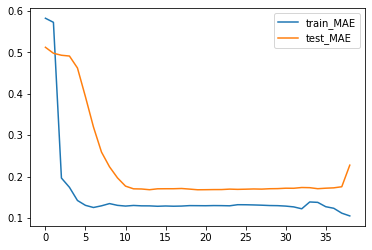

MAE = 0.1683 NMAE = 0.2889

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 280, 11)           44        
_________________________________________________________________
lstm_0_1 (LSTM)              (None, 280, 125)          68500     
_________________________________________________________________
dropout_0_1 (Dropout)        (None, 280, 125)          0         
_________________________________________________________________
batch_norm_0_1 (BatchNormali (None, 280, 125)          500       
_________________________________________________________________
lstm_0_2 (LSTM)              (None, 280, 255)          388620    
_________________________________________________________________
dropout_0_2 (Dropout)        (None, 280, 255)          0         
_________________________________________________________________
lstm_1_1 (LSTM)           

In [14]:
n_in = gp_result.x[0]

num_test = max(floor(df.shape[0]*(1-percent_train)), n_out)
df_test = df.drop(df.tail(n_out).index).tail(num_test+n_in)
df_train = df.drop(df.tail(n_out+num_test).index)
train_X, train_y = split_data(df_train, df.columns, n_in, n_out)
test_X, test_y = split_data(df_test, df.columns, n_in, n_out)
test_y_mean = np.mean(test_y)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

num_trials = 5
best_nmae = 9999.9999
best_model = None

early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    patience=gp_result.x[8], 
    restore_best_weights=True
)
for t in range(num_trials):
    print("Trial %i" %(t+1))
    model = build_model(
        learning_rate=gp_result.x[1], 
        LSTM1=gp_result.x[2],
        LSTM2=gp_result.x[3],
        num_layers=gp_result.x[4],
        dropout1=gp_result.x[5], 
        dropout2=gp_result.x[6],
        n_out=n_out,
        n_in=n_in,
        n_features=len(df.columns)
    )
    history = model.fit(
        x=train_X,
        y=train_y,
        epochs=gp_result.x[9], 
        batch_size=gp_result.x[7],
        validation_data=(test_X, test_y), 
        shuffle=False, 
        verbose=0,
        callbacks=[early_stopping])
    pyplot.figure()
    pyplot.plot(history.history['loss'], label='train_MAE')
    pyplot.plot(history.history['val_loss'], label='test_MAE')
    pyplot.legend()
    pyplot.show()

    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore', message='All-NaN axis encountered')
        mae = np.nanmin(history.history['val_loss'][-1*gp_result.x[8]:])

    # calculate NMAE
    normalized_mae = mae/test_y_mean
    print('MAE = %.4f NMAE = %.4f' % (mae, normalized_mae))
    
    if normalized_mae < best_nmae:
        best_nmae = normalized_mae
        best_model = model
    else:
        del model
print()
print(best_model.summary())

In [15]:
df_predict = df.tail(n_out+n_in)
predict_X, predict_y = split_data(df_predict, df.columns, n_in, n_out)

# Make Prediction
yhat = best_model.predict(predict_X)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df["Close"].values.reshape(-1,1))
inv_y = scaler.inverse_transform(predict_y).reshape(n_out*n_predict)
inv_yhat = scaler.inverse_transform(yhat.reshape(-1,1)).reshape(n_out*n_predict)
# calculate RMSE and NRMSE
normalized_rmse = sqrt(tf.keras.metrics.mean_squared_error(inv_y, inv_yhat))/mean(inv_y)
mae = tf.keras.metrics.mean_absolute_error(inv_y, inv_yhat)
normalized_mae = mae/tf.math.reduce_mean(inv_y)
print('MAE = %.4f NMAE = %.4f NRMSE = %.4f' % (mae, normalized_mae, normalized_rmse), end="")

MAE = 7.7475 NMAE = 0.1469 NRMSE = 0.1829

In [16]:
predictDates = dates[len(dates)-(n_out*n_predict):]
numQuarters = floor(n_out / 90)
quarter = floor(n_out/numQuarters)
print(quarter)
maxes = [predictDates[np.argmax(inv_yhat[0:quarter], axis=0)]]
maxes_actual = [predictDates[np.argmax(inv_y[0:quarter], axis=0)]]
for i in range(0, numQuarters-1):
    maxes.append(predictDates[np.argmax(inv_yhat[quarter*(i+1):quarter*(i+2)-1], axis=0)+quarter*(i+1)])
    maxes_actual.append(predictDates[np.argmax(inv_y[quarter*(i+1):quarter*(i+2)-1], axis=0)+quarter*(i+1)])

91


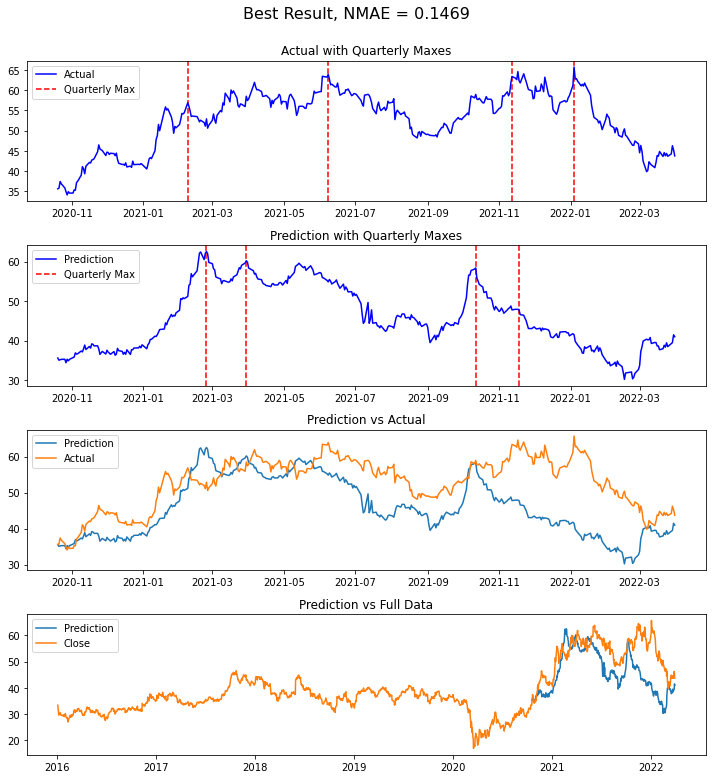

In [17]:
# Plot of Prediction vs Actual
pyplot.figure(figsize=(10,11))

pyplot.suptitle("Best Result, NMAE = %.4f\n" %(normalized_mae), fontsize=16)
pyplot.subplot(4, 1, 1)
pyplot.plot(predictDates, inv_y, color='b', label="Actual", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes_actual[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes_actual[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Actual with Quarterly Maxes")

pyplot.subplot(4, 1, 2)
pyplot.plot(predictDates, inv_yhat, color='b', label="Prediction", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Prediction with Quarterly Maxes")

pyplot.subplot(4,1,3)
pyplot.plot(predictDates, inv_yhat, label="Prediction")
pyplot.plot(predictDates, inv_y, label="Actual")
pyplot.legend(loc='upper left')
pyplot.title("Prediction vs Actual")

pyplot.subplot(4,1,4)
pyplot.plot(predictDates, inv_yhat, label="Prediction")
pyplot.plot(dates, df["Close"], label="Close")
pyplot.legend(loc='upper left')
pyplot.title("Prediction vs Full Data")

pyplot.tight_layout()
pyplot.show()

In [18]:
# Printing the dates of each quarterly maximum
for i in range(len(maxes)):
    print("Q%i Max: %s" %(i+1, maxes[i]))
    print("Q%i Actual Max: %s" %(i+1, maxes_actual[i]))
    print("Diff: %s" %abs((maxes_actual[i]-maxes[i]).astype('timedelta64[D]')))

Q1 Max: 2021-02-24T00:00:00.000000000
Q1 Actual Max: 2021-02-08T00:00:00.000000000
Diff: 16 days
Q2 Max: 2021-03-30T00:00:00.000000000
Q2 Actual Max: 2021-06-08T00:00:00.000000000
Diff: 70 days
Q3 Max: 2021-10-12T00:00:00.000000000
Q3 Actual Max: 2021-11-12T00:00:00.000000000
Diff: 31 days
Q4 Max: 2021-11-18T00:00:00.000000000
Q4 Actual Max: 2022-01-04T00:00:00.000000000
Diff: 47 days


In [19]:
from datetime import date

best_model.save('SavedModel_%s_%.4f.h5' % (date.today(), normalized_mae))